# Analysis of ChIP-seq simulation

See `chips` folder for scripts.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [2]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [3]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

Modification                                              Model         k  \
0      H3K27ac  /home/jetbrains/data/2023_chips/models/H3K27ac...  9.698845   
1     H3K27me3  /home/jetbrains/data/2023_chips/models/H3K27me...  7.710403   
2     H3K36me3  /home/jetbrains/data/2023_chips/models/H3K36me...  8.121823   
3      H3K4me1  /home/jetbrains/data/2023_chips/models/H3K4me1...  7.084311   
4      H3K4me3  /home/jetbrains/data/2023_chips/models/H3K4me3...  5.655991   

       theta  prc_rate         f         s  
0  28.720036       1.0  0.016691  0.543023  
1  32.211166       1.0  0.003799  0.186056  
2  31.384718       1.0  0.021185  0.649353  
3  33.604404       1.0  0.016509  0.742254  
4  37.608902       1.0  0.005437  0.738595

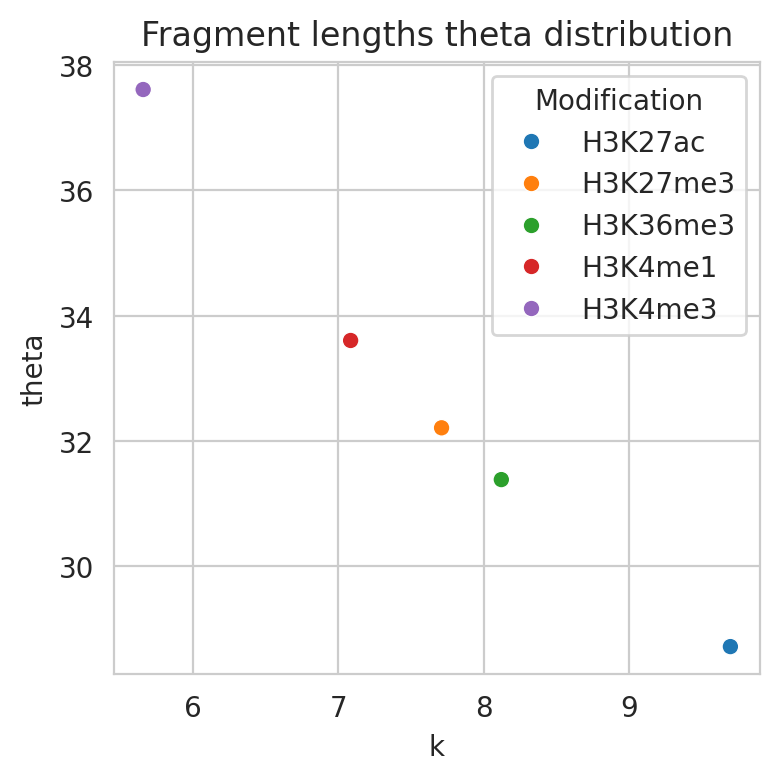

In [4]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

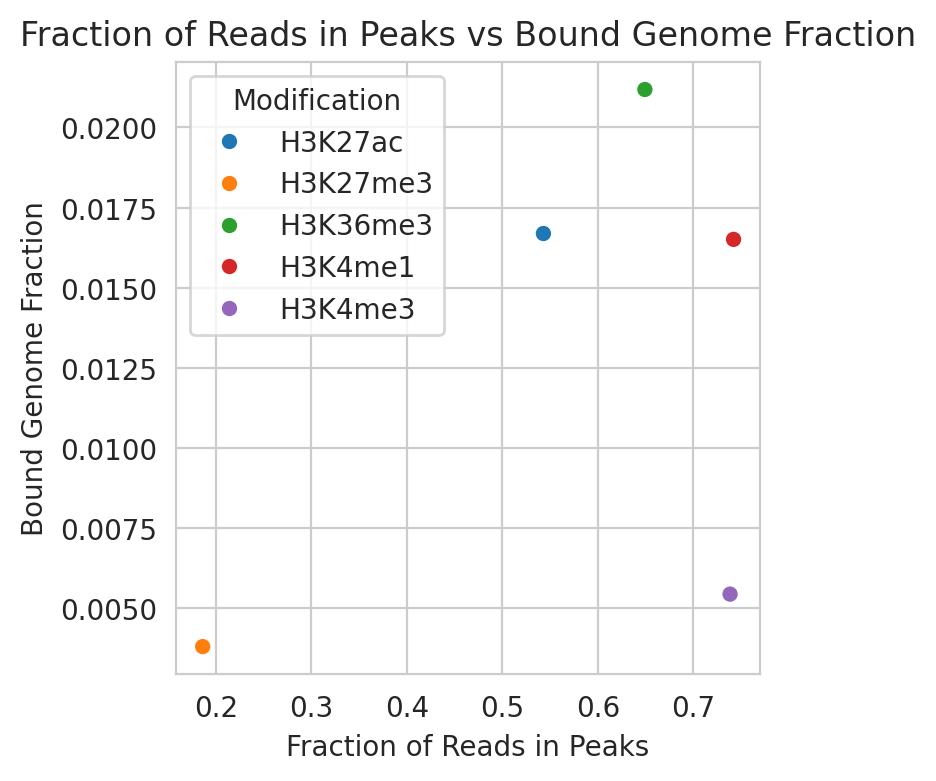

In [5]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [7]:
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [8]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [9]:
from itertools import product
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], 
            range(1, N + 1), 
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 1:
            print(f'WARNING, more than 1 found for {path} {suffix}')
        for f in res:
            df_fdr.loc[len(df_fdr)] = (f, m, n, mult)
    return df_fdr

# Load peaks

In [10]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))
df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))
df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))
df_span = load_peaks(PATH + '/span', '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

df_peaks = pd.concat([df_macs2, df_macs2broad, df_span, df_sicer]).reset_index(drop=True)
df_peaks['quality'] = [f'{int(m * 100)}%' for m in df_peaks['multiplier']]
df_peaks.sample(5)

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

SPAN 150


file modification  n  \
495  /home/jetbrains/data/2023_chips/sicer/H3K27ac_...      H3K27ac  5   
341  /home/jetbrains/data/2023_chips/span/H3K27ac_c...      H3K27ac  4   
271  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  5   
558  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  2   
1    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3  1   

     multiplier         tool quality  
495         1.0        SICER    100%  
341         0.7         SPAN     70%  
271         0.7  MACS2 broad     70%  
558         0.2        SICER     20%  
1           0.7        MACS2     70%

# Estimate overlap with ground truth peaks

In [11]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(df_peaks[['file', 'modification', 'n']].iterrows()):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    true_overlap = lines(tf)
    !bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    overlap = lines(tf)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))
    
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 
                             'true_overlap', 'overlap', 'overlap_len'])
for c in t.columns:
    df_peaks[c] = list(t[c])
del t

df_peaks['Precision'] = df_peaks['overlap'] / df_peaks['peaks']
df_peaks['Recall'] = df_peaks['true_overlap'] / df_peaks['true_peaks']
df_peaks['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df_peaks['Precision'], df_peaks['Recall'])]
df_peaks['Jaccard'] = df_peaks['overlap_len'] / (df_peaks['true_length'] + df_peaks['length'] - df_peaks['overlap_len'])


df_peaks.sample(5)

0it [00:00, ?it/s]

file modification  n  \
213  /home/jetbrains/data/2023_chips/macs2/H3K4me1_...      H3K4me1  3   
161  /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3  3   
289  /home/jetbrains/data/2023_chips/macs2/mixed_k4...        mixed  3   
475  /home/jetbrains/data/2023_chips/sicer/H3K27ac_...      H3K27ac  1   
581  /home/jetbrains/data/2023_chips/sicer/mixed_k4...        mixed  2   

     multiplier         tool quality  \
213         0.2  MACS2 broad     20%   
161         0.7  MACS2 broad     70%   
289         0.1  MACS2 broad     10%   
475         1.0        SICER    100%   
581         0.7        SICER     70%   

                                       true_peaks_file  true_peaks  \
213  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
161  /home/jetbrains/data/2023_chips/fastq/H3K4me3_...         500   
289  /home/jetbrains/data/2023_chips/fastq/mixed_k4...         500   
475  /home/jetbrains/data/2023_chips/fastq/H3K27ac_...         500   
581  /home/jetbrains/data/2023_chips/fastq/mixed_k4...         500   

     true_length  peaks     length  true_overlap  overlap  overlap_len  \
213       601688    217   248391.0           150      196       237105   
161       466144    462   504114.0           370      370       417219   
289      2342492    500   428778.0            48      477       419595   
475       557666    717  1600683.0           487      487       552757   
581      2106480    381  2217619.0           381      379      2071078   

     Precision  Recall        F1   Jaccard  
213   0.903226   0.300  0.450402  0.386811  
161   0.800866   0.740  0.769231  0.754412  
289   0.954000   0.096  0.174446  0.178424  
475   0.679219   0.974  0.800329  0.344270  
581   0.994751   0.762  0.862957  0.919245

# Peaks number and lengths

In [12]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

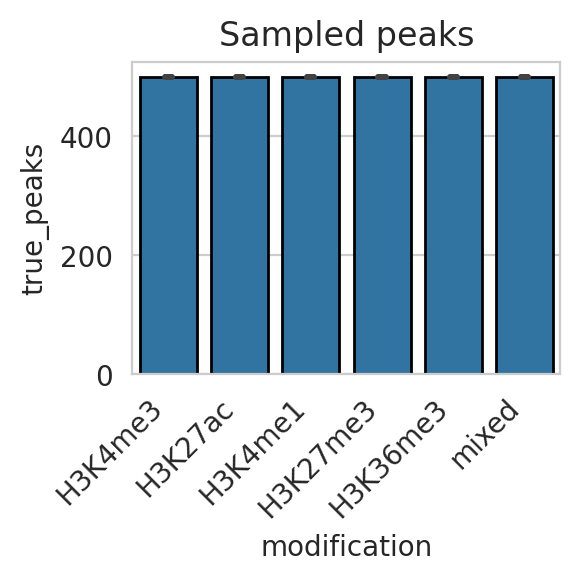

In [13]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df_peaks, x="modification", y="true_peaks",
            capsize=.1, err_kws={'linewidth': 2}, edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [14]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_original = pd.concat(ts).reset_index(drop=True)
del ts
t_original

length modification
0        1464      H3K4me3
1        1466      H3K4me3
2        3752      H3K4me3
3         938      H3K4me3
4        2450      H3K4me3
...       ...          ...
99995    5999     H3K36me3
99996    6999     H3K36me3
99997    4999     H3K36me3
99998   10799     H3K36me3
99999    5999     H3K36me3

[100000 rows x 2 columns]

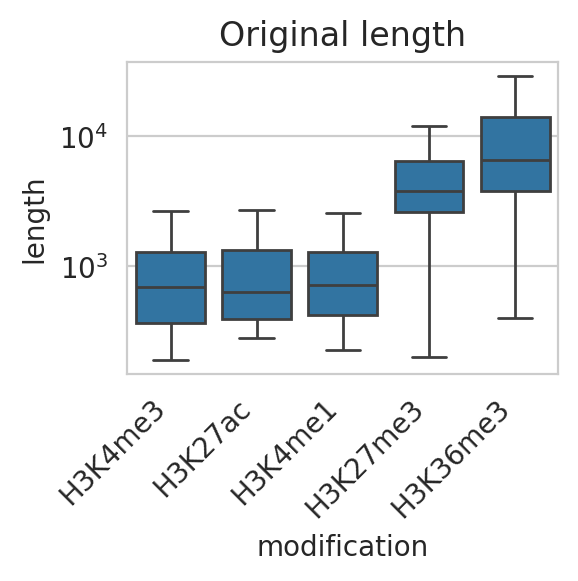

In [15]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
sns.boxplot(data=t_original, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
ax.set(yscale='log')
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

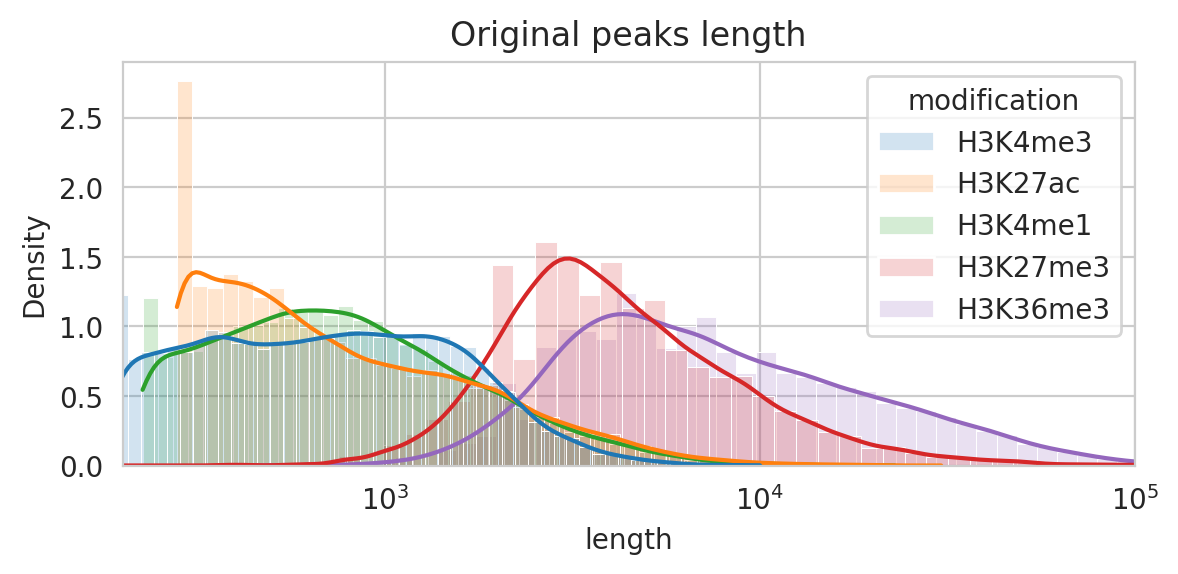

In [16]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_original, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [17]:
ts = []
for _, (m, file) in df_peaks[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_true_peaks = pd.concat(ts).reset_index(drop=True)
del ts
t_true_peaks

length modification
0          263      H3K4me3
1          191      H3K4me3
2          314      H3K4me3
3         2797      H3K4me3
4         1157      H3K4me3
...        ...          ...
299995    9399        mixed
299996   30999        mixed
299997     351        mixed
299998     217        mixed
299999   10199        mixed

[300000 rows x 2 columns]

/tmp/ipykernel_3292062/951696089.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


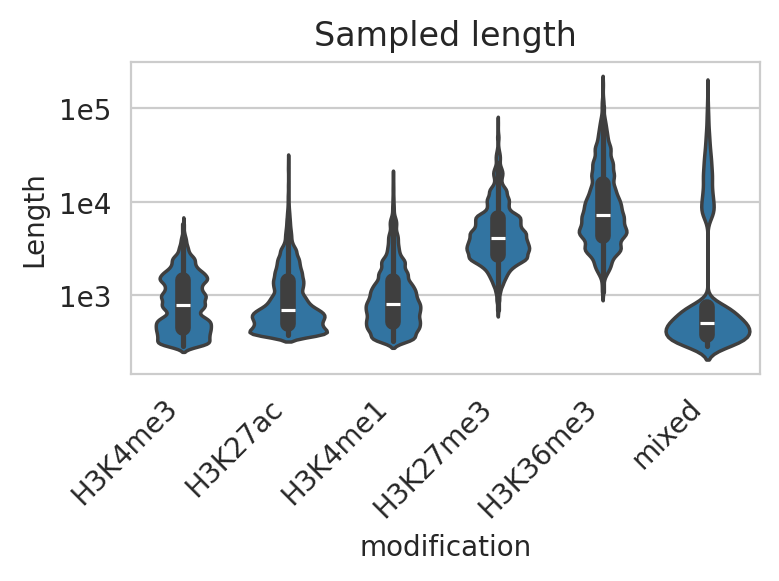

In [18]:
fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
t_true_peaks['log_length'] = np.log10(t_true_peaks['length'] + 100)
sns.violinplot(data=t_true_peaks, x="modification", y="log_length",
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('Length')
plt.title('Sampled length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_3292062/3808701143.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


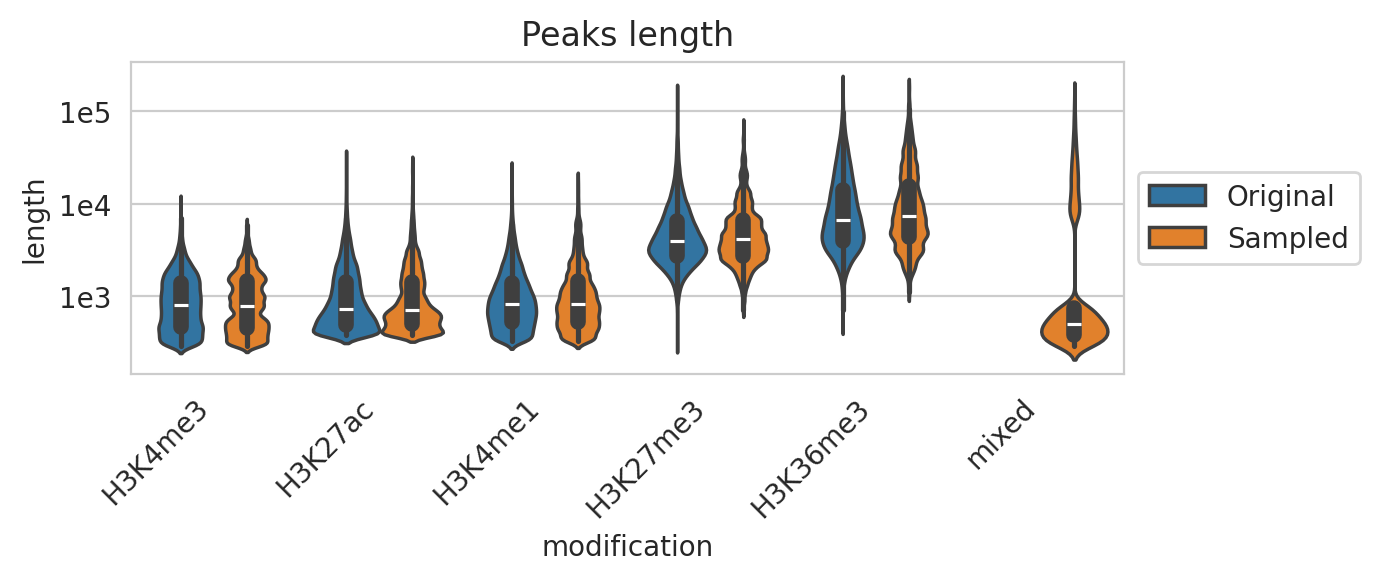

In [19]:
t_original['type'] = 'Original'
t_true_peaks['type'] = 'Sampled'
t = pd.concat([t_original, t_true_peaks]).reset_index(drop=True)
t['log_length'] = np.log10(t['length'] + 100)
plt.figure(figsize=(7, 3))
ax = plt.axes()
sns.violinplot(data=t,
               x="modification", y="log_length",
               # showfliers=False,
               hue='type', hue_order=['Original', 'Sampled'],
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
# Put a legend to the right of the current axix
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
# ax.set(yscale='log')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('length')
plt.title('Peaks length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

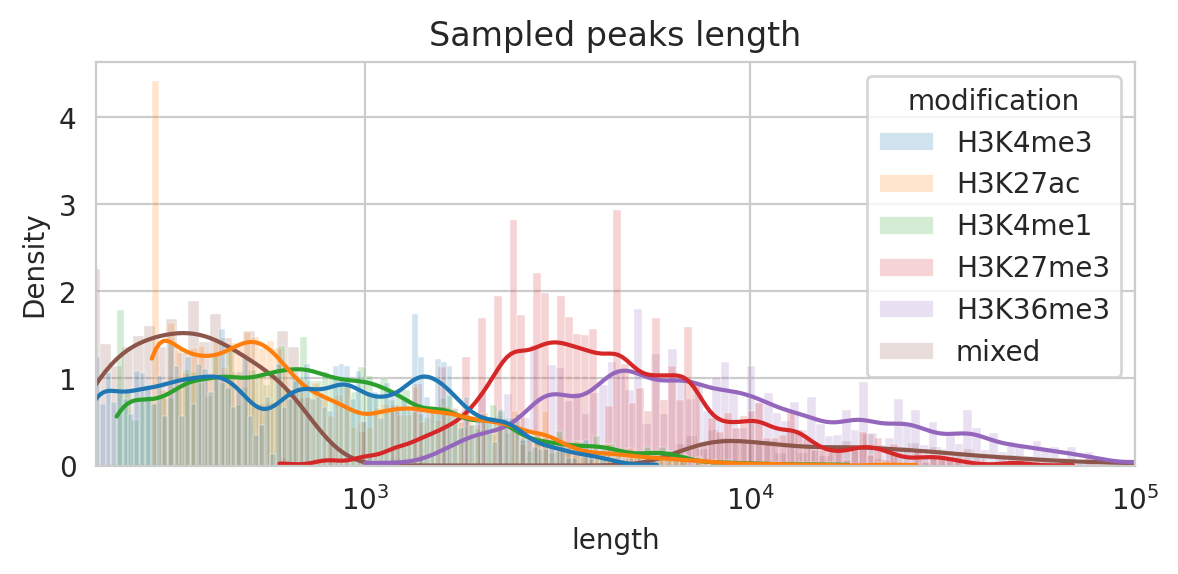

In [20]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.histplot(data=t_true_peaks, x='length', hue='modification',
             stat='density', common_bins=False, common_norm=False,
             bins=100, kde=True, log_scale=True, alpha=0.2,
             hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
             ax=ax)
ax.set(xscale='log')
ax.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
# Put a legend to the right of the current axix
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

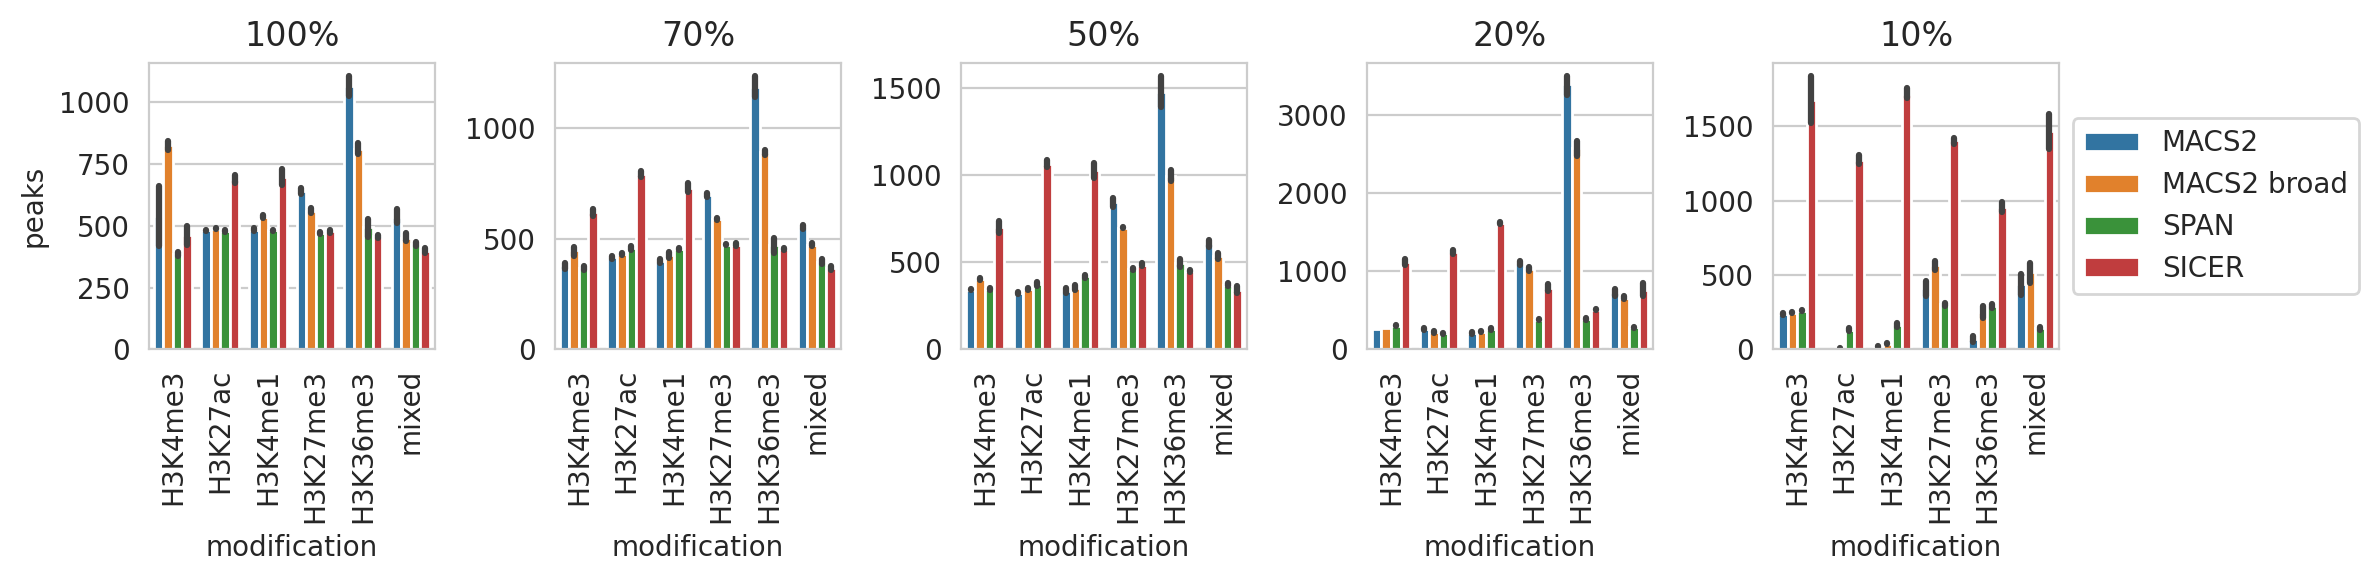

In [21]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [22]:
df_peaks[(df_peaks['quality'] == '100%') & (df_peaks['modification'] == 'H3K36me3')]

file modification  n  \
100  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
105  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  2   
110  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  3   
115  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  4   
120  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  5   
250  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
255  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  2   
260  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  3   
265  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  4   
270  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  5   
400  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  1   
405  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  2   
410  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  3   
415  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  4   
420  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  5   
550  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  1   
555  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  2   
560  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  3   
565  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  4   
570  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  5   

     multiplier         tool quality  \
100         1.0        MACS2    100%   
105         1.0        MACS2    100%   
110         1.0        MACS2    100%   
115         1.0        MACS2    100%   
120         1.0        MACS2    100%   
250         1.0  MACS2 broad    100%   
255         1.0  MACS2 broad    100%   
260         1.0  MACS2 broad    100%   
265         1.0  MACS2 broad    100%   
270         1.0  MACS2 broad    100%   
400         1.0         SPAN    100%   
405         1.0         SPAN    100%   
410         1.0         SPAN    100%   
415         1.0         SPAN    100%   
420         1.0         SPAN    100%   
550         1.0        SICER    100%   
555         1.0        SICER    100%   
560         1.0        SICER    100%   
565         1.0        SICER    100%   
570         1.0        SICER    100%   

                                       true_peaks_file  true_peaks  \
100  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
105  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
110  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
115  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
120  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
250  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
255  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
260  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
265  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
270  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
400  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
405  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
410  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
415  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
420  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
550  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
555  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
560  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
565  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
570  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   

     true_length  peaks     length  true_overlap  overlap  overlap_len  \
100      6868300   1099  5665263.0           334     1099      5650777   
105      6744700   1014  5599723.0 

In [23]:
ts = []
for _, (m, q, tool, file) in df_peaks[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

length modification quality   tool
0        478.0      H3K4me3    100%  MACS2
1       1480.0      H3K4me3    100%  MACS2
2        729.0      H3K4me3    100%  MACS2
3        901.0      H3K4me3    100%  MACS2
4        460.0      H3K4me3    100%  MACS2
...        ...          ...     ...    ...
357757   599.0        mixed     10%  SICER
357758   999.0        mixed     10%  SICER
357759   999.0        mixed     10%  SICER
357760   999.0        mixed     10%  SICER
357761  2399.0        mixed     10%  SICER

[357762 rows x 4 columns]

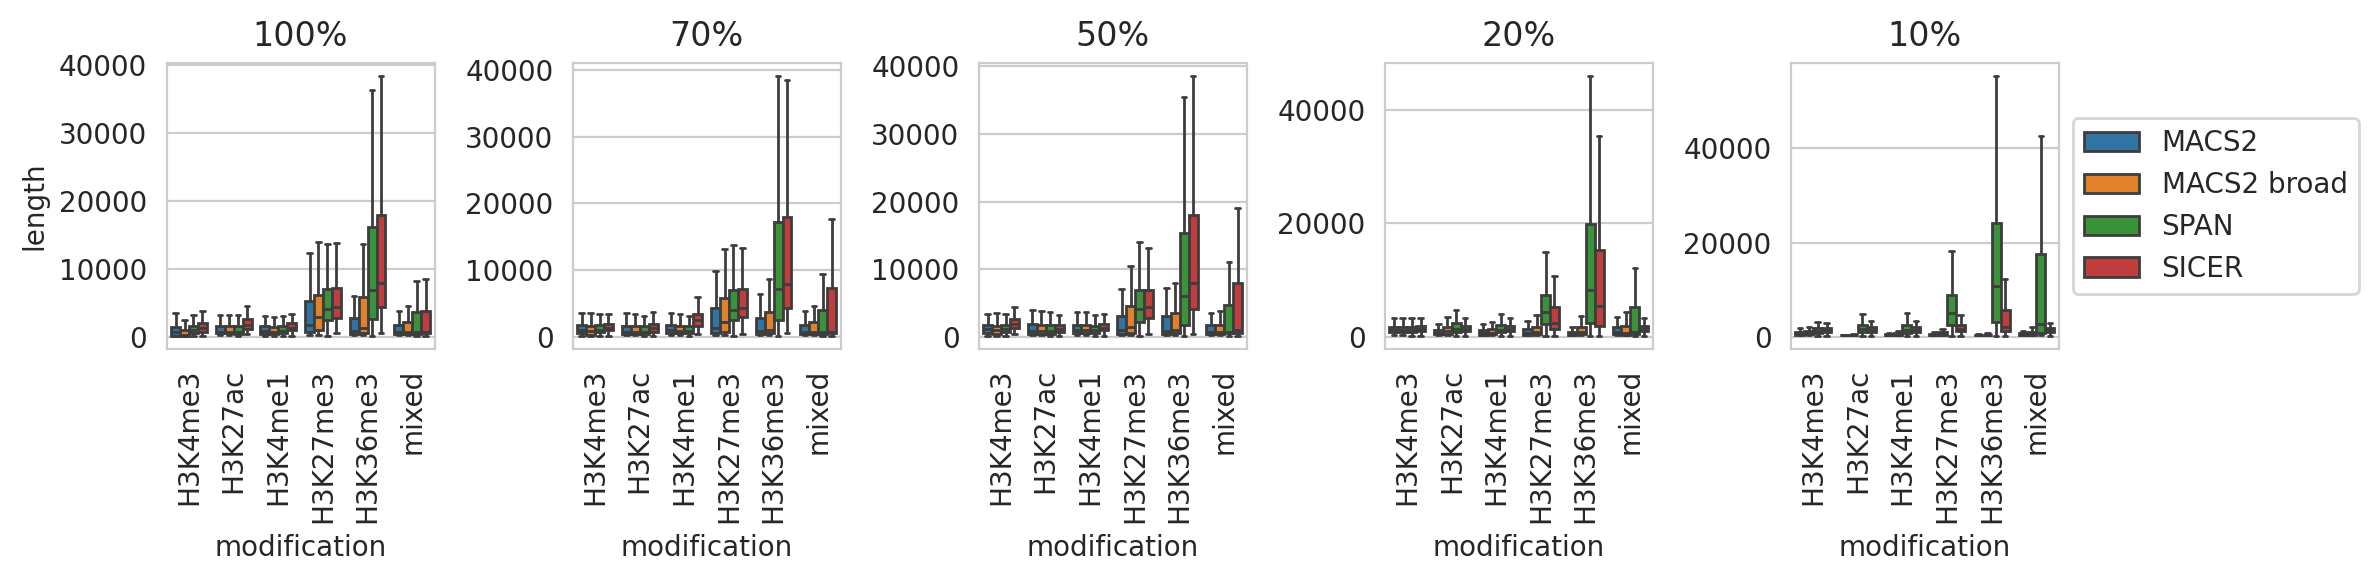

In [24]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

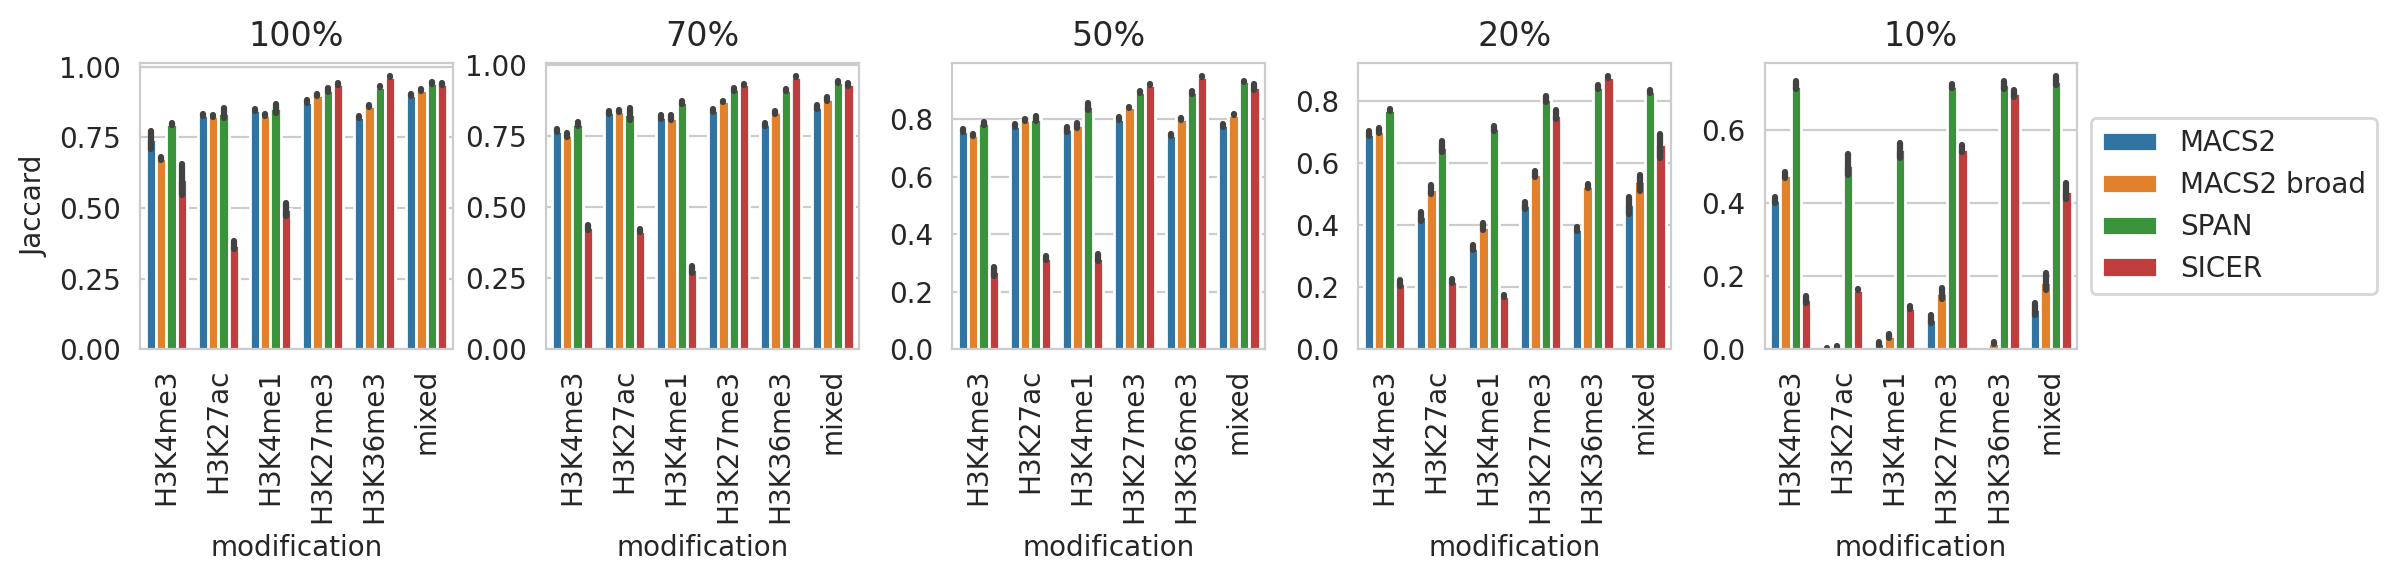

In [25]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [26]:
df_peaks0 = df_peaks.copy()
# Add 0.0 multiplier
for m, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], TOOLS):
    row = [None, m, None, 0.0, tool, '0%'] + [None] * (len(df_peaks.columns) - 7) + [0.0]
    df_peaks0.loc[len(df_peaks0)] = row
df_peaks0

/tmp/ipykernel_3292062/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_3292062/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_3292062/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retai

file modification     n  \
0    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
1    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
2    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
3    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
4    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
..                                                 ...          ...   ...   
619                                               None     H3K36me3  None   
620                                               None        mixed  None   
621                                               None        mixed  None   
622                                               None        mixed  None   
623                                               None        mixed  None   

     multiplier         tool quality  \
0           1.0        MACS2    100%   
1           0.7        MACS2     70%   
2           0.5        MACS2     50%   
3           0.2        MACS2     20%   
4           0.1        MACS2     10%   
..          ...          ...     ...   
619         0.0        SICER      0%   
620         0.0        MACS2      0%   
621         0.0  MACS2 broad      0%   
622         0.0         SPAN      0%   
623         0.0        SICER      0%   

                                       true_peaks_file true_peaks true_length  \
0    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
1    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
2    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
3    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
4    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
..                                                 ...        ...         ...   
619                                               None       None        None   
620                                               None       None        None   
621                                               None       None        None   
622                                               None       None        None   
623                                               None       None        None   

    peaks    length true_overlap overlap overlap_len  Precision  Recall  \
0     724  553939.0          398     401      408267   0.553867   0.796   
1     394  463046.0          359     367      393356   0.931472   0.718   
2     345  432379.0          329     335      378729   0.971014   0.658   
3     258  358434.0          253     256      327744   0.992248   0.506   
4     238  195186.0          184     235      187942   0.987395   0.368   
..    ...       ...          ...     ...         ...        ...     ...   
619  None       NaN         None    None        None        NaN     NaN   
620  None       NaN         None    None        None        NaN     NaN   
621  None       NaN         None    None        None        NaN     NaN   
622  None       NaN         None    None        None        NaN     NaN   
623  None       NaN         None    None        None        NaN     NaN   

           F1   Jaccard  
0    0.653217  0.689963  
1    0.810922  0.762701  
2    0.784434  0.757911  
3    0.670219  0.687468  
4    0.536170  0.414613  
..        ...       ...  
619       NaN  0.000000  
620       NaN  0.000000  
621       NaN  0.000000  
622       NaN  0.000000  
623       NaN  0.000000  

[624 rows x 18 columns]

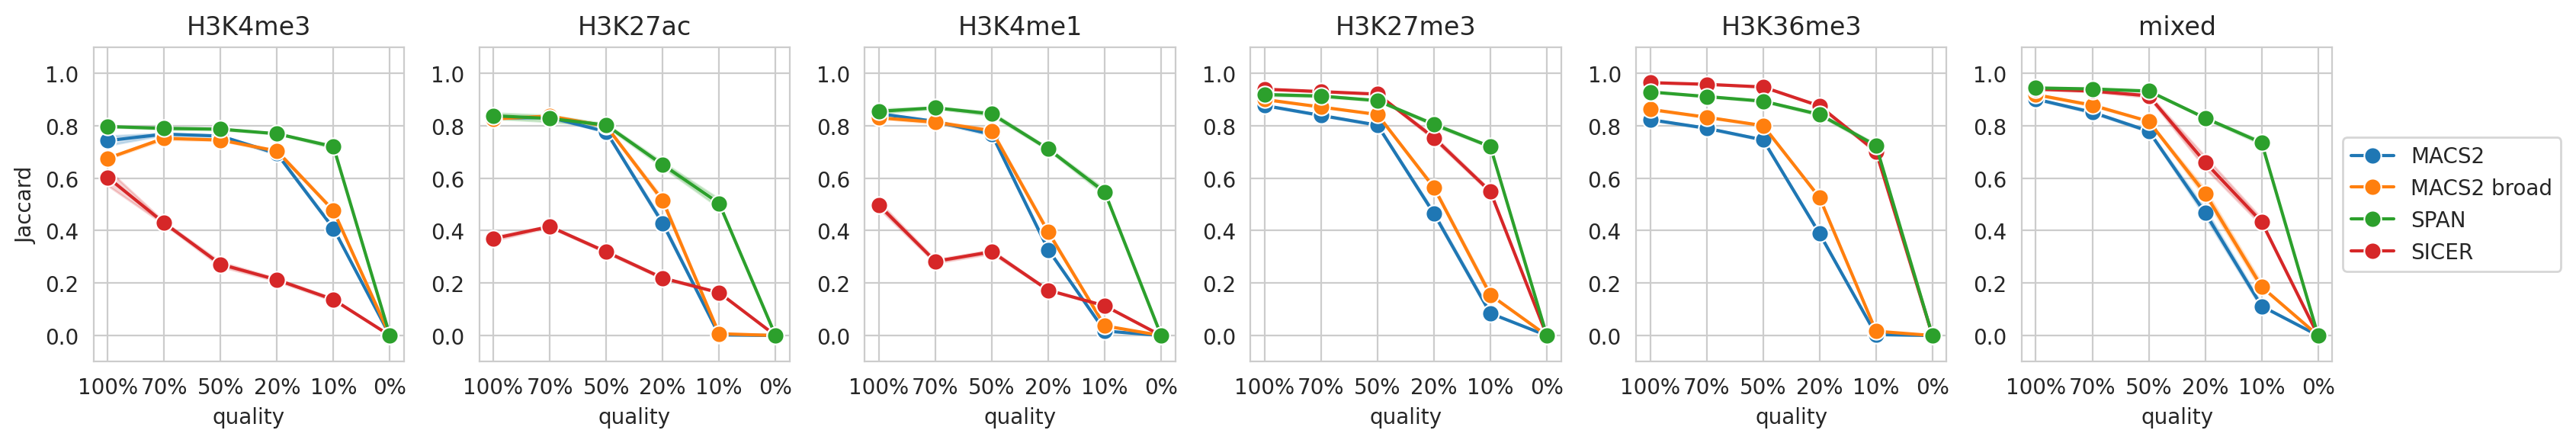

In [27]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] != 'SPAN')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] == 'SPAN')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8,
                 legend=False)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

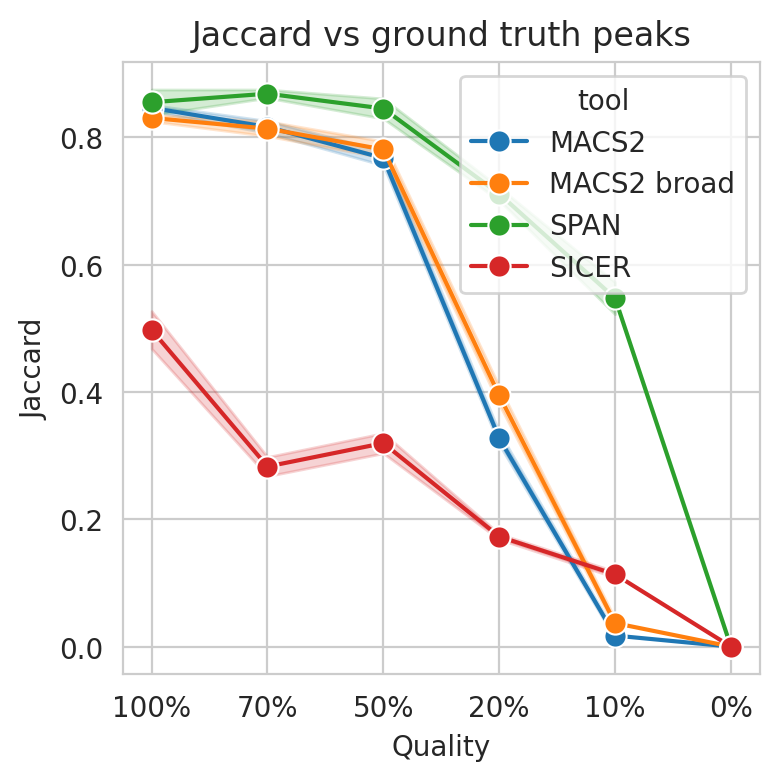

In [28]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks0[df_peaks0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

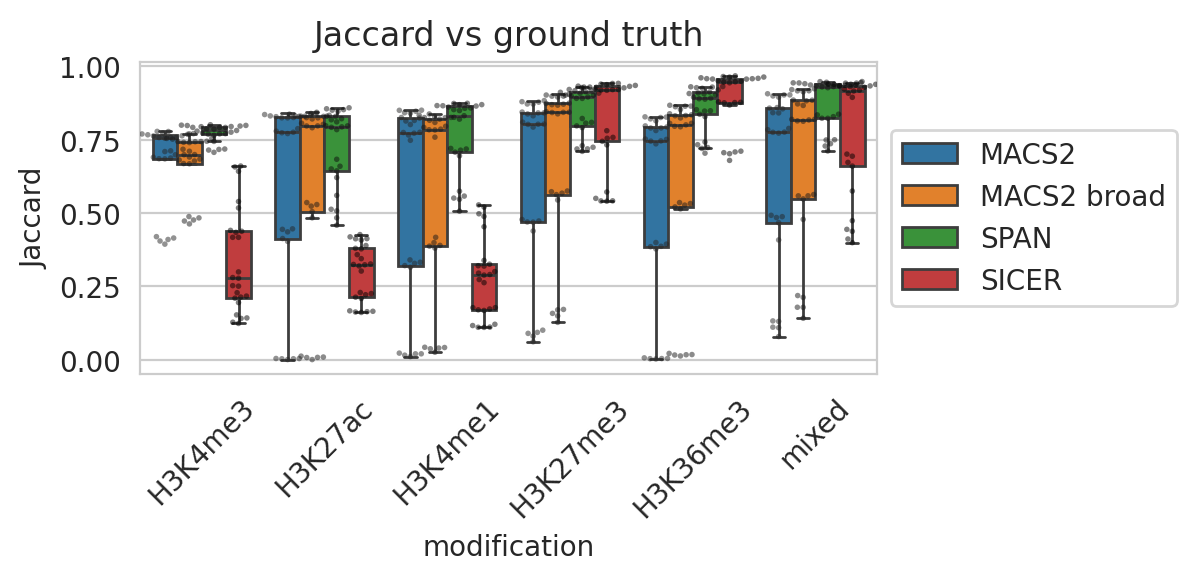

In [29]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_peaks[df_peaks['multiplier'] > 0],
            x='modification', y='Jaccard', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            palette=TOOLS_PALETTE,
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_peaks[df_peaks['multiplier'] > 0],
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard vs ground truth')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [30]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
12      H3K27ac  4        MACS2  0.619579
5       H3K27ac  2  MACS2 broad  0.640130
11      H3K27ac  3         SPAN  0.724057

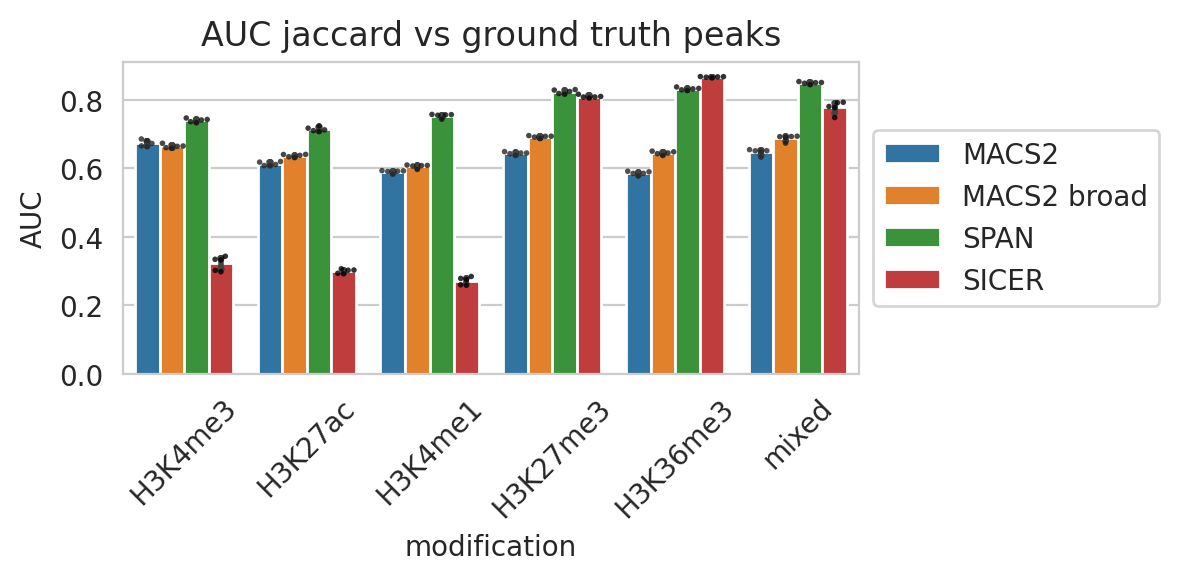

In [31]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs ground truth peaks')
sns.barplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
            capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


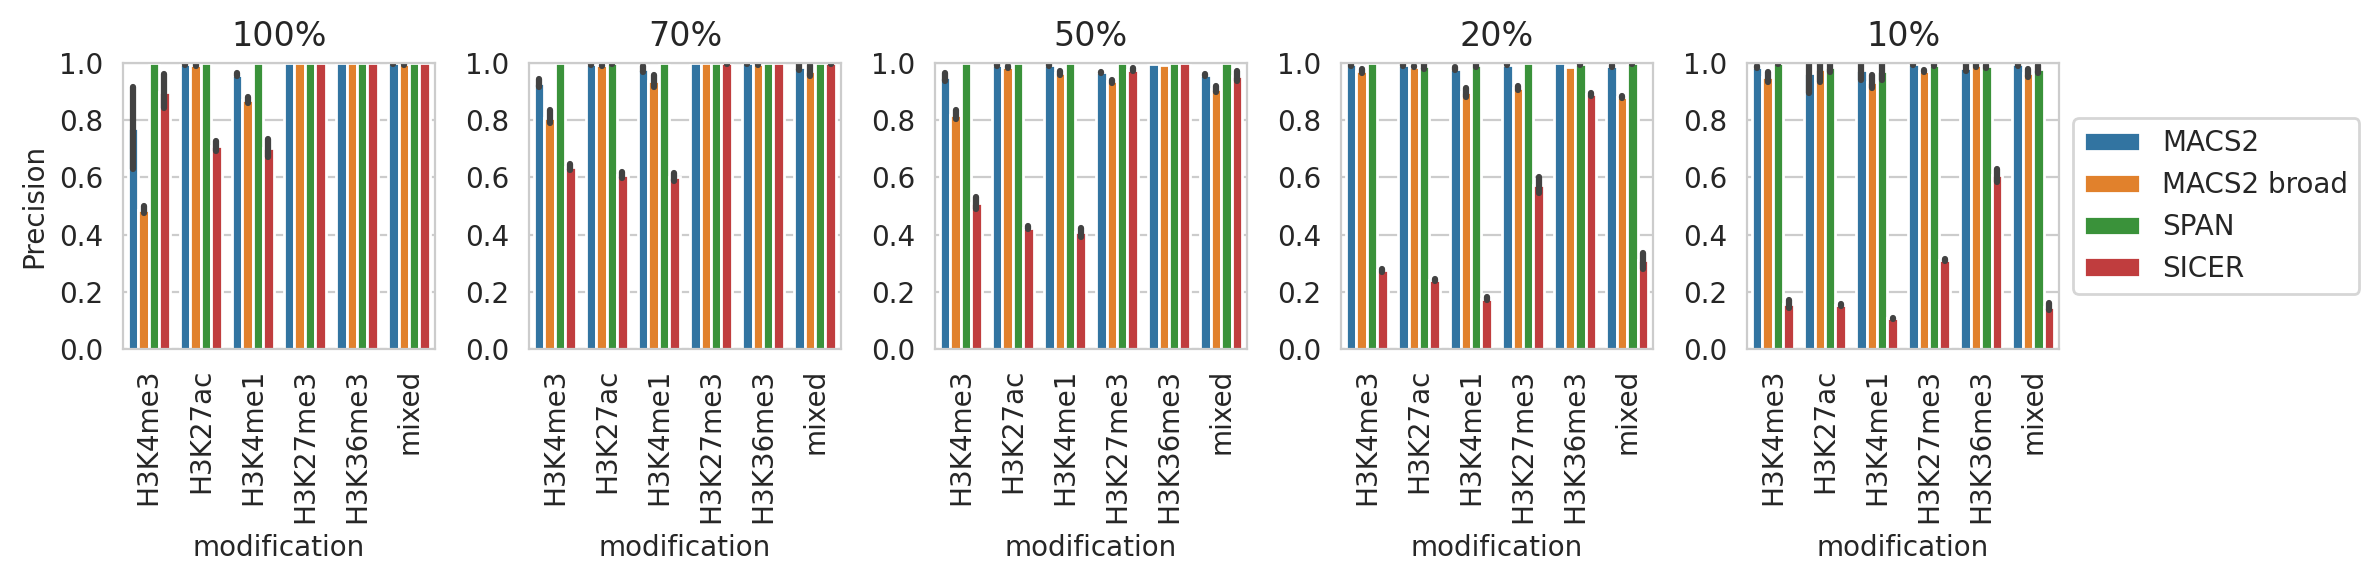

Recall


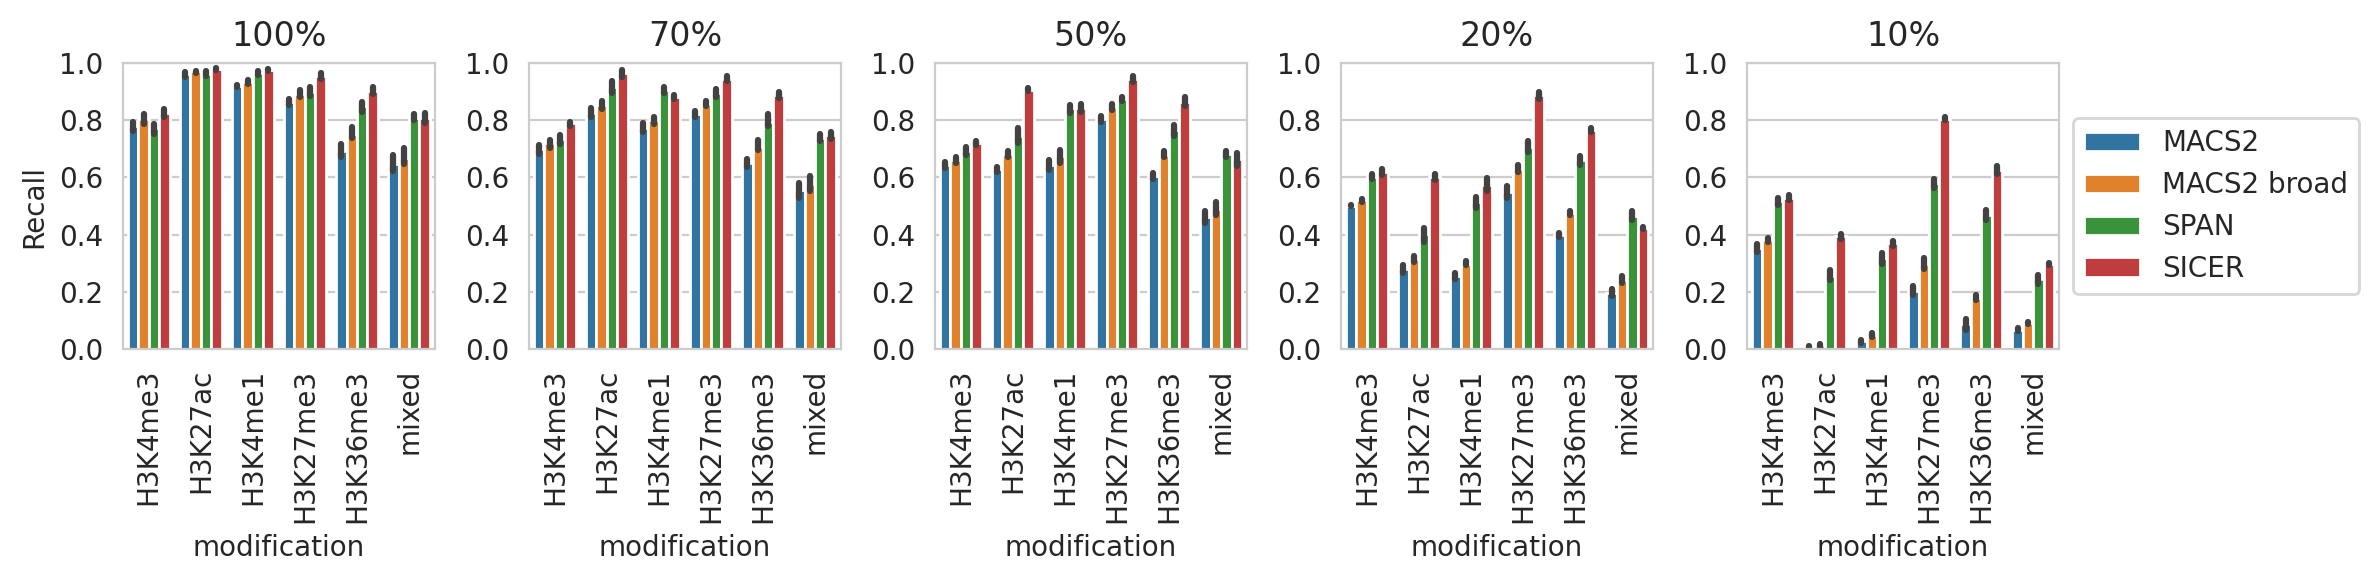

F1


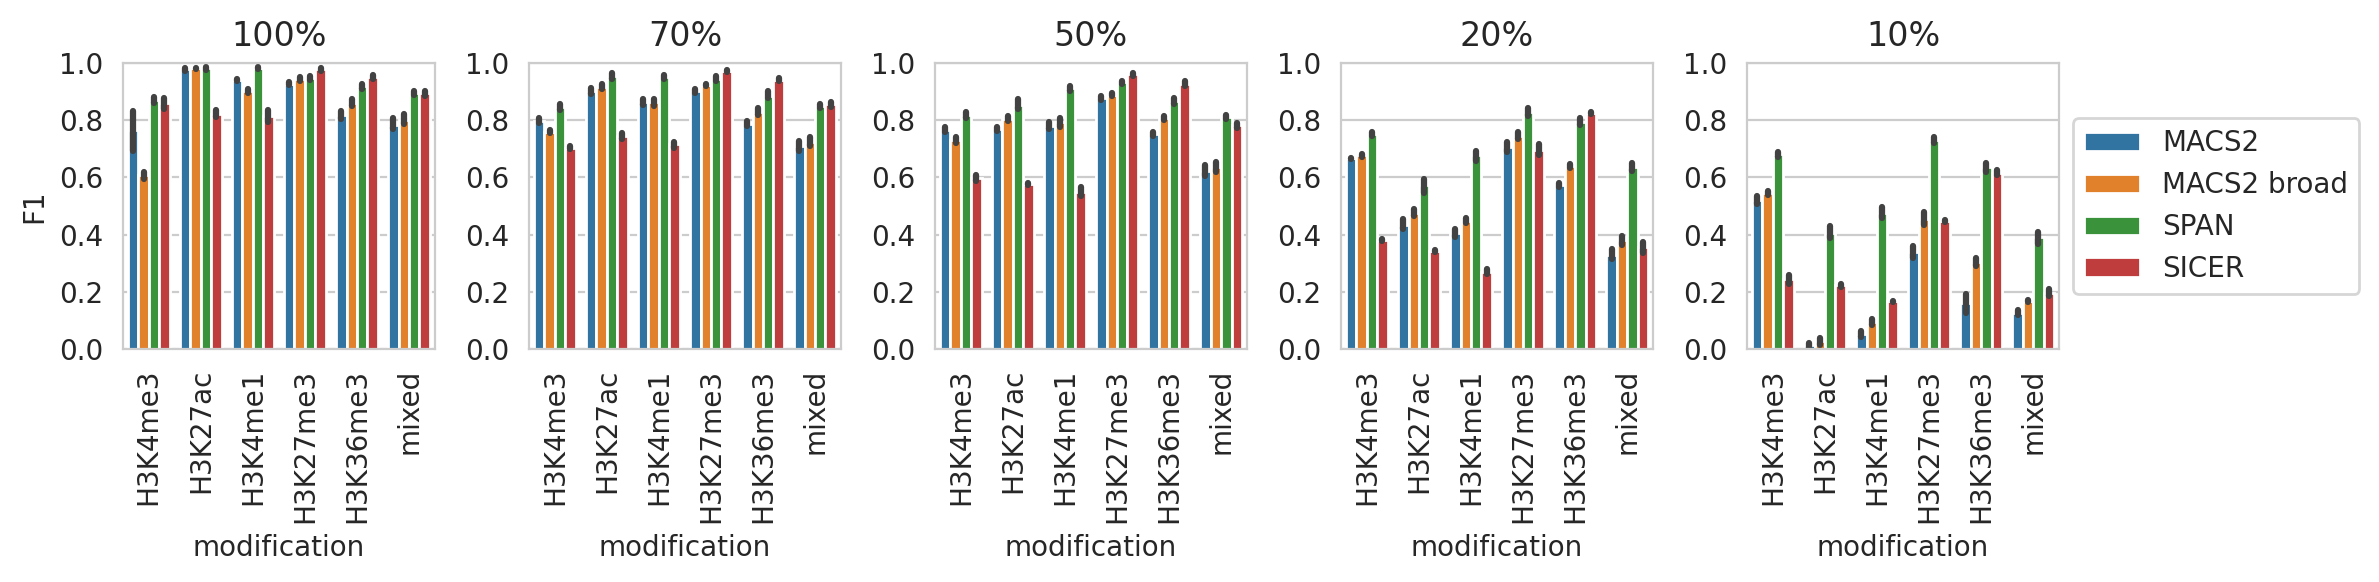

In [32]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, q in enumerate(df_peaks['quality'].unique()):
        if q == '0%':
            continue
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['quality'] == q)], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == len(axs) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

/tmp/ipykernel_3292062/1893111183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10')


  0%|          | 0/6 [00:00<?, ?it/s]

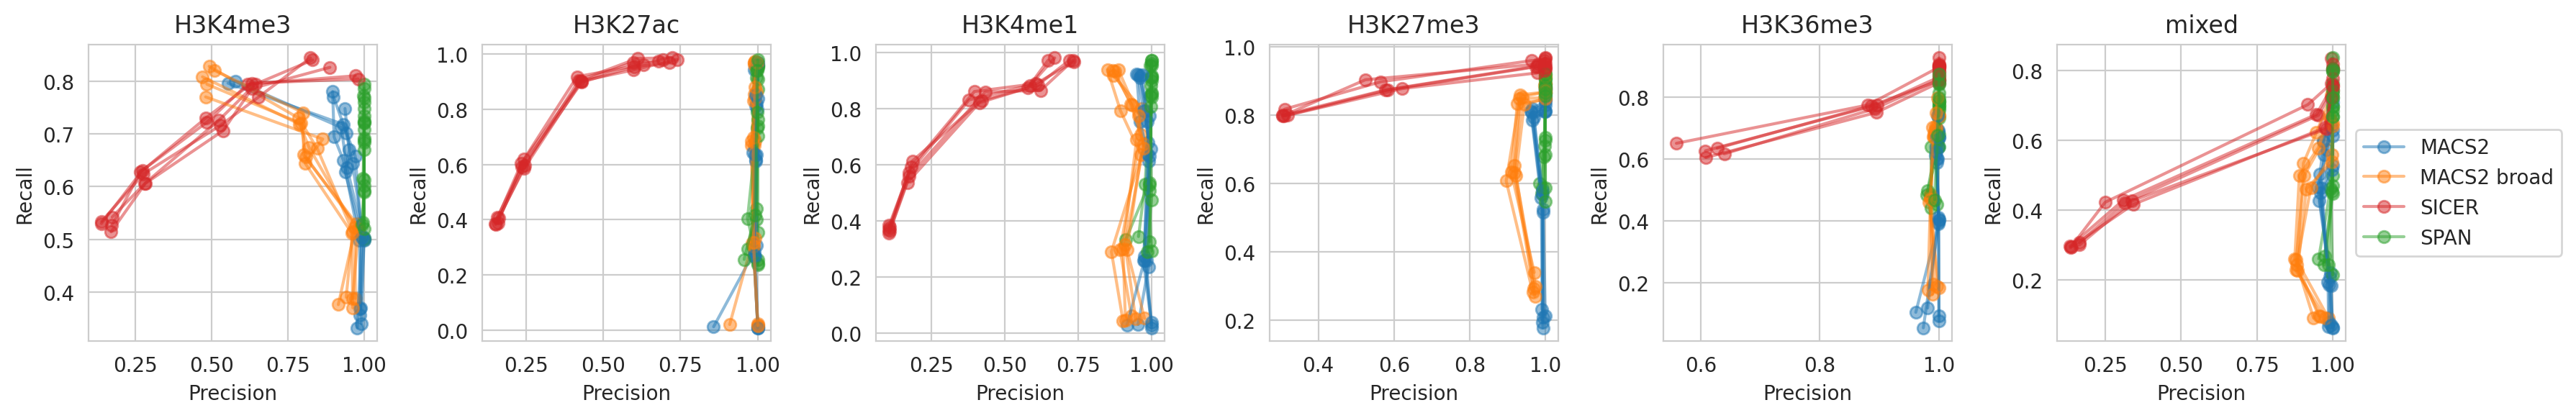

In [33]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['n', 'tool']):
        if m == 'mixed' and tool not in labels:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.5)
            labels.append(tool)
        else:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', color=TOOLS_PALETTE[tool], alpha=0.5)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

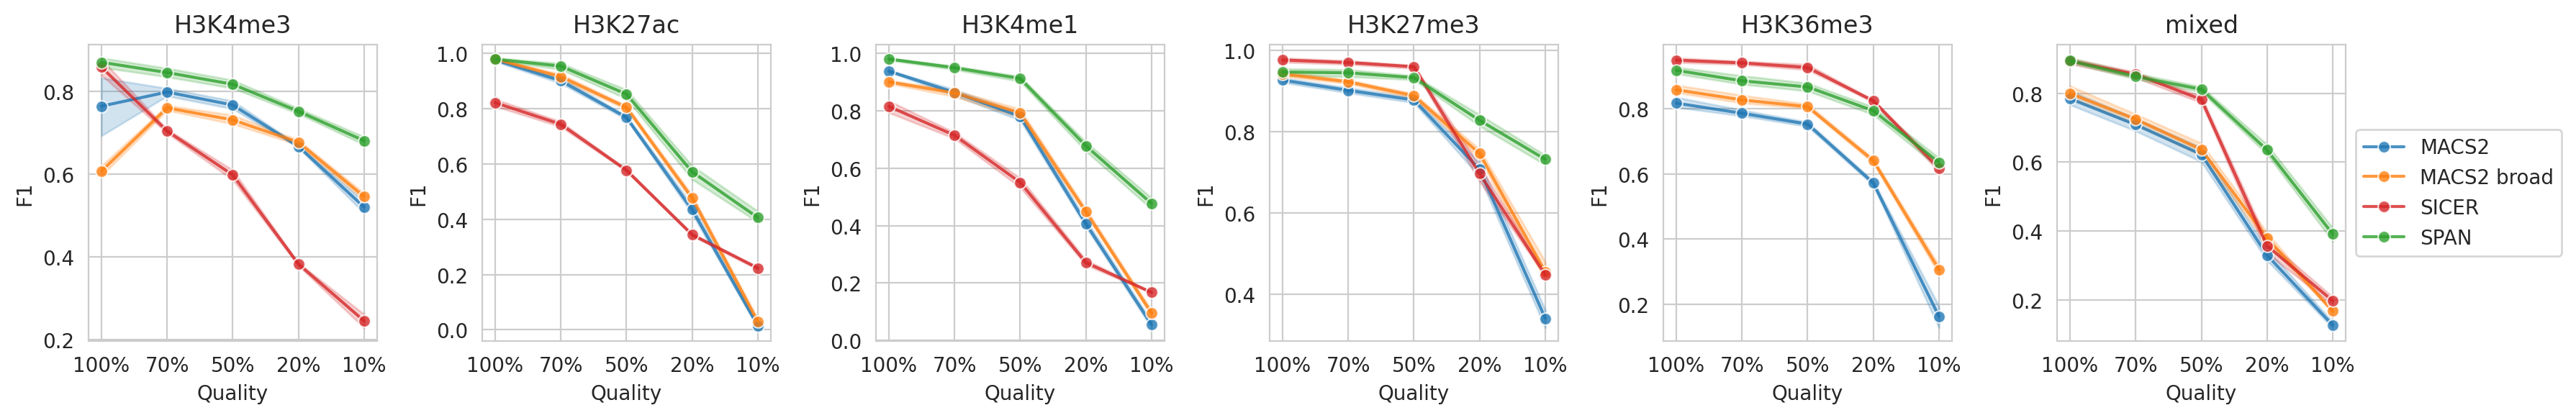

In [34]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once 
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for tool, dft in df_peaks[df_peaks['modification'] == m].groupby('tool'):
        if m == 'mixed' and tool not in labels:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
            labels.append(tool)
        else:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
    ax.set_xlabel('Quality')
    ax.set_ylabel('F1')
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

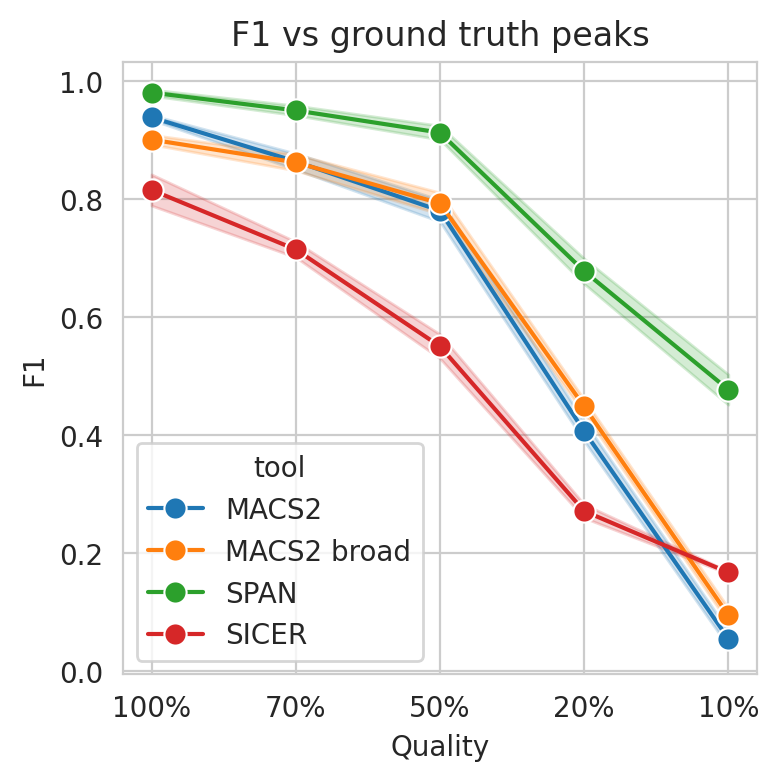

In [35]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks[df_peaks['modification'] == 'H3K4me1'], x="quality", y="F1", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('F1 vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

In [36]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    f1prev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['F1'] + f1prev) / 2
        mprev, f1prev = row['multiplier'], row['F1']
    t.append((m, n, tool, aj))
dff1auc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dff1auc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
76      H3K4me1  5        MACS2  0.633652
23     H3K27me3  1         SPAN  0.848932
25     H3K27me3  2  MACS2 broad  0.781300

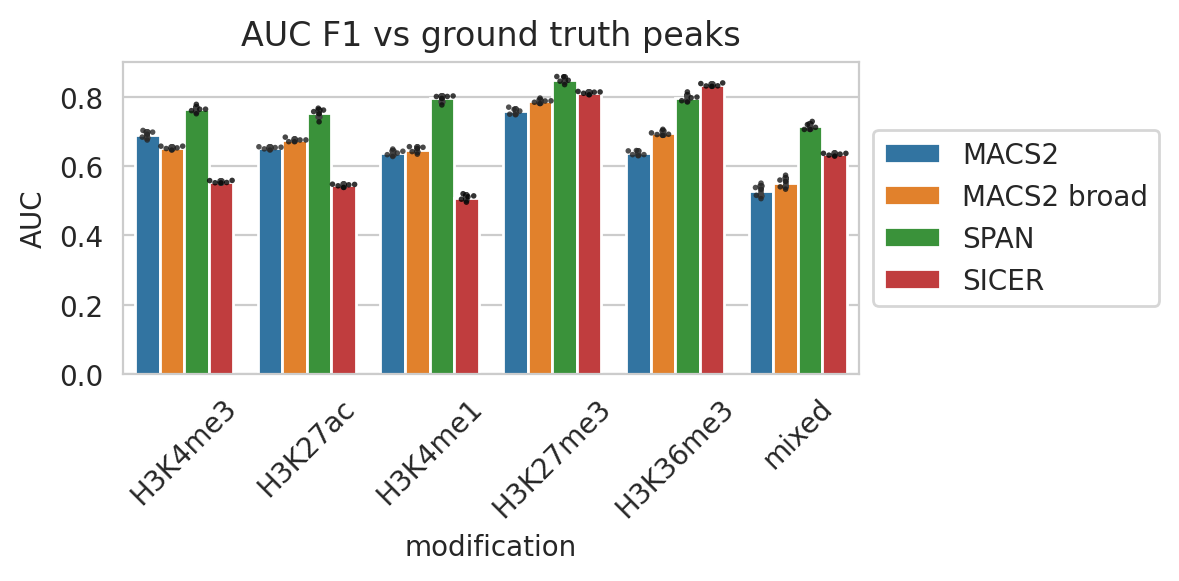

In [37]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC F1 vs ground truth peaks')
sns.barplot(data=dff1auc, x='modification', y='AUC',hue='tool',
            capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dff1auc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8,
              palette="dark:black",
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Overlap vs 100% quality peaks

In [38]:
rows = []
tf = tempfile.mktemp()
for (m, n, t), dft in tqdm(df_peaks.groupby(['modification', 'n', 'tool'])):
    print(m, n, t)
    peaks_file100 = dft[dft['multiplier'] == 1.0]['file'].values[0]
    for _, (file, mult) in dft[dft['multiplier'] != 1.0][['file', 'multiplier']].iterrows():
        peaks100 = lines(peaks_file100)
        length100 = bedl(peaks_file100).sum()
        peaks = lines(file)
        length = bedl(file).sum()
        peaks_file100_s = sorted_file(peaks_file100)
        file_s = sorted_file(file)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wa -u > {tf}
        overlap100 = lines(tf)
        !bedtools intersect -b {peaks_file100_s} -a {file_s} -wa -u > {tf}
        overlap = lines(tf)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        rows.append((m, n, t, mult, peaks_file100, peaks100, length100, peaks, length, overlap100, overlap, overlap_len))

overlap100_df = pd.DataFrame(rows, columns=['modification', 'n', 'tool', 'multiplier',
                             'peaks_file100', 'peaks100', 'length100',
                             'peaks', 'length',
                             'overlap100', 'overlap', 'overlap_len'])
del rows

overlap100_df['Precision'] = overlap100_df['overlap'] / overlap100_df['peaks']
overlap100_df['Recall'] = overlap100_df['overlap100'] / overlap100_df['peaks100']
overlap100_df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(overlap100_df['Precision'], overlap100_df['Recall'])]
overlap100_df['Jaccard'] = overlap100_df['overlap_len'] / (overlap100_df['length100'] + overlap100_df['length'] - overlap100_df['overlap_len'])
overlap100_df['quality'] = [f'{int(m * 100)}%' for m in overlap100_df['multiplier']]

overlap100_df.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SICER
H3K27ac 1 SPAN
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SICER
H3K27ac 2 SPAN
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SICER
H3K27ac 3 SPAN
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SICER
H3K27ac 4 SPAN
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SICER
H3K27ac 5 SPAN
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 SICER
H3K27me3 1 SPAN
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 SICER
H3K27me3 2 SPAN
H3K27me3 3 MACS2
H3K27me3 3 MACS2 broad
H3K27me3 3 SICER
H3K27me3 3 SPAN
H3K27me3 4 MACS2
H3K27me3 4 MACS2 broad
H3K27me3 4 SICER
H3K27me3 4 SPAN
H3K27me3 5 MACS2
H3K27me3 5 MACS2 broad
H3K27me3 5 SICER
H3K27me3 5 SPAN
H3K36me3 1 MACS2
H3K36me3 1 MACS2 broad
H3K36me3 1 SICER
H3K36me3 1 SPAN
H3K36me3 2 MACS2
H3K36me3 2 MACS2 broad
H3K36me3 2 SICER
H3K36me3 2 SPAN
H3K36me3 3 MACS2
H3K36me3 3 MACS2 broad
H3K36me3 3 SICER
H3K36me3 3 SPAN
H3K36me3 4 MACS2
H3K36me3 4 MACS2 broad
H3K36me3 4 SICER
H3K36me3 4 SPA

modification  n         tool  multiplier  \
29       H3K27ac  2         SPAN         0.5   
36       H3K27ac  3  MACS2 broad         0.7   
157     H3K27me3  5         SPAN         0.5   

                                         peaks_file100  peaks100  length100  \
29   /home/jetbrains/data/2023_chips/span/H3K27ac_c...       479     615100   
36   /home/jetbrains/data/2023_chips/macs2/H3K27ac_...       487     654978   
157  /home/jetbrains/data/2023_chips/span/H3K27me3_...       465    2904400   

     peaks     length  overlap100  overlap  overlap_len  Precision    Recall  \
29     355   511200.0         350      354       502800   0.997183  0.730689   
36     422   583838.0         416      416       577538   0.985782  0.854209   
157    467  2818500.0         436      455      2781200   0.974304  0.937634   

           F1   Jaccard quality  
29   0.843385  0.806415     50%  
36   0.915292  0.873366     70%  
157  0.955618  0.945440     50%

In [39]:
overlap100_df0 = overlap100_df.copy()
# Add 1.0 and 0.0 multiplier
for m, n, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, 6), TOOLS):
    row = [m, n, tool, 0.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    row = [m, n, tool, 1.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'quality'] = '0%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'quality'] = '100%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'Jaccard'] = 0
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'Jaccard'] = 1
overlap100_df0.sort_values(by=['modification', 'n', 'tool', 'multiplier'], ascending=False, inplace=True)
overlap100_df0.tail(3)

/tmp/ipykernel_3292062/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_3292062/3784053421.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_3292062/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the res

modification  n   tool  multiplier  \
2        H3K27ac  1  MACS2         0.2   
3        H3K27ac  1  MACS2         0.1   
520      H3K27ac  1  MACS2         0.0   

                                         peaks_file100 peaks100 length100  \
2    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      479    646060   
3    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      479    646060   
520                                               None     None      None   

    peaks    length overlap100 overlap overlap_len  Precision    Recall  \
2     255  233377.0        133     252      232482   0.988235  0.277662   
3       5    1914.0          5       5        1914   1.000000  0.010438   
520  None       NaN       None    None        None        NaN       NaN   

           F1   Jaccard quality  
2    0.433519  0.359348     20%  
3    0.020661  0.002963     10%  
520       NaN  0.000000      0%

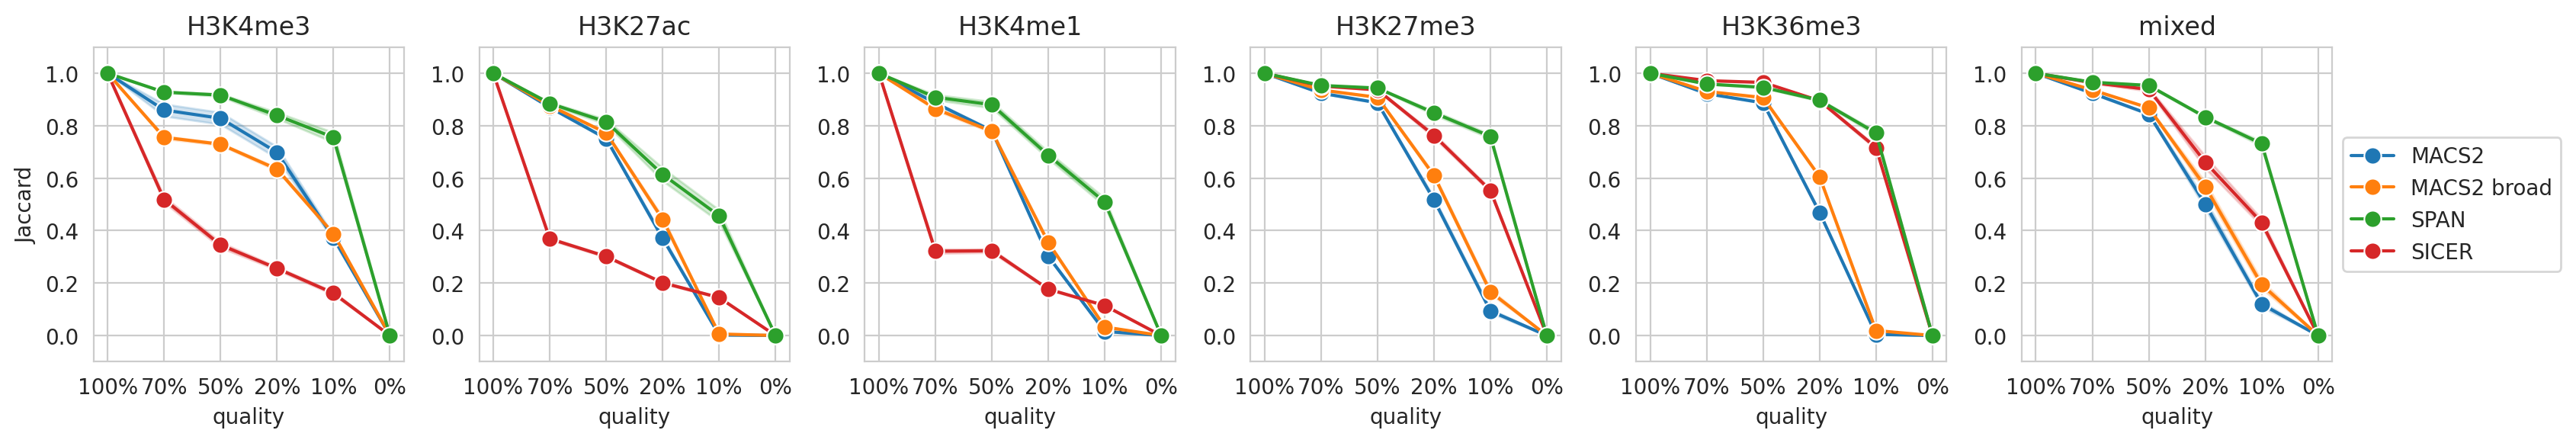

In [40]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] != 'SPAN')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] == 'SPAN')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE, legend=False,
                 errorbar='se',
                 marker='o', markersize=8)
    
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

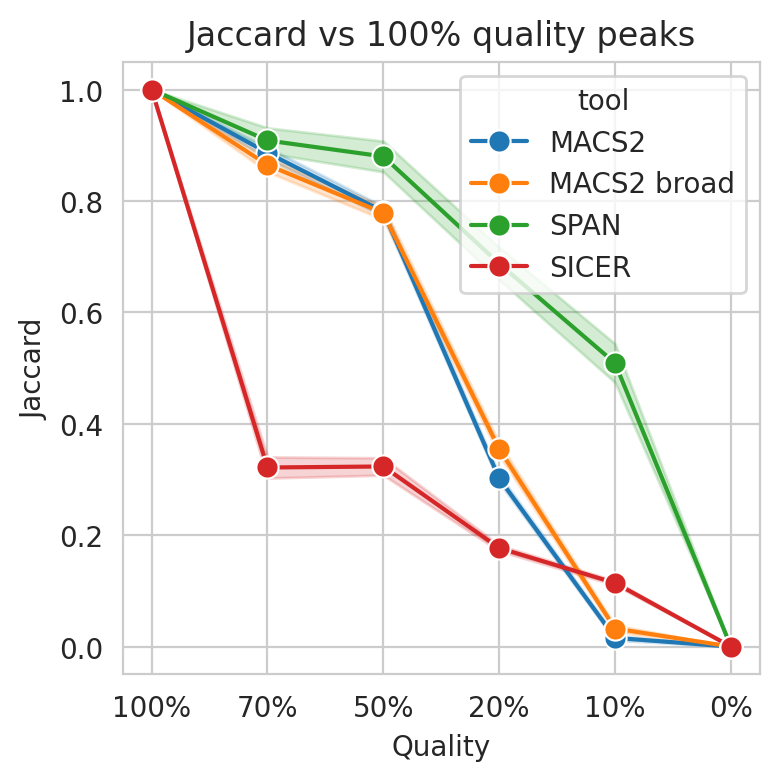

In [41]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs 100% quality peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [42]:
t = []
for (m, n, tool), dft in tqdm(list(overlap100_df0[overlap100_df0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc100 = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc100.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
25     H3K27me3  2  MACS2 broad  0.749537
83      H3K4me3  1         SPAN  0.856960
87      H3K4me3  2         SPAN  0.845470

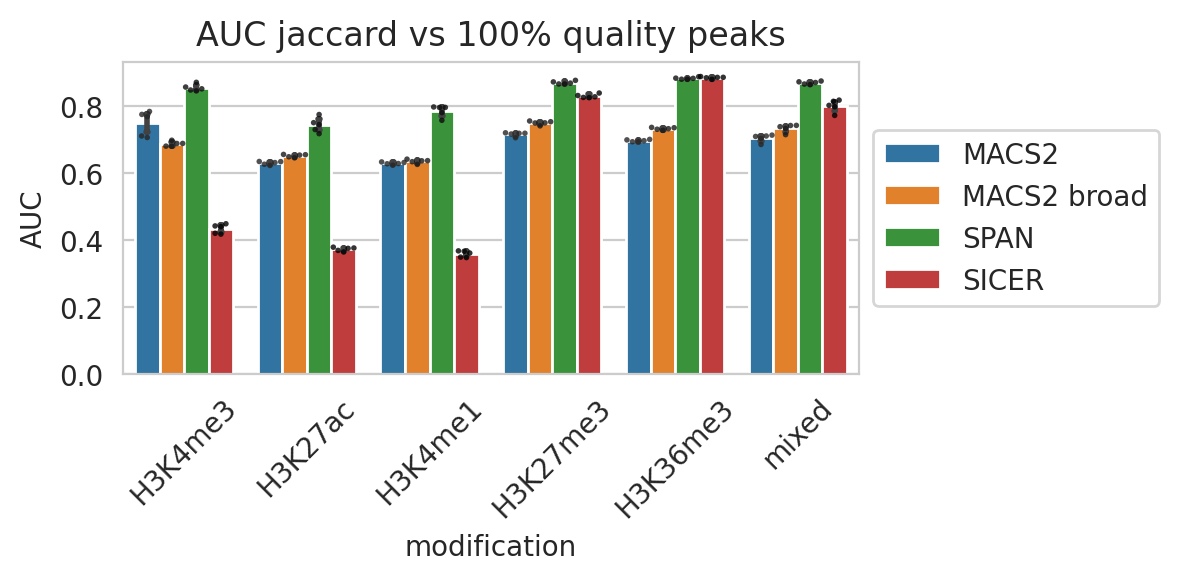

In [43]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs 100% quality peaks')
sns.barplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
            capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [44]:
dfjaccardauc100[(dfjaccardauc100['modification'] == 'mixed') & (dfjaccardauc100['tool'] == 'SPAN')]

modification  n  tool       AUC
103        mixed  1  SPAN  0.865962
107        mixed  2  SPAN  0.864021
111        mixed  3  SPAN  0.870481
115        mixed  4  SPAN  0.874939
119        mixed  5  SPAN  0.872564

# END